Файл 'teen_phone_addiction_dataset.csv' успешно загружен.
Вариант N=10. Индекс: 3.
Выбран столбец для анализа: Screen_Time_Before_Bed

--------------------------------------------------
=== ЧАСТЬ I: Описательная статистика ===

1. Среднее: 1.0067333333333335
2. Дисперсия (несмещенная): 0.24292897187951631
3. Мода: 1.0
4. Медиана: 1.0
5. Квантили (0.25, 0.5, 0.75): [0.7 1.  1.4]
6. Эксцесс (Fisher): -0.35033868704647286
7. Асимметрия: 0.09837930491958932
8. IQR (Интерквартильный размах): 0.7


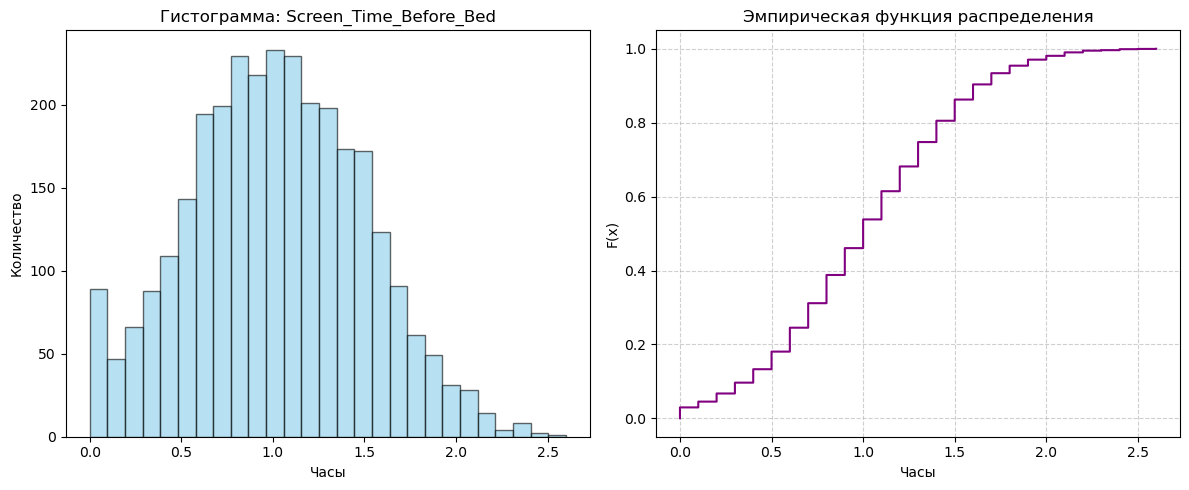


--------------------------------------------------
=== ЧАСТЬ II: Проверка на нормальность ===

[Ручной Хи-квадрат]
Статистика: 200.8067 | Критическое значение: 16.9190
Вывод: Гипотеза о нормальности ОТВЕРГАЕТСЯ.

[Критерий Асимметрии и Эксцесса]
Асимметрия: 0.098 (Z = 2.200)
Эксцесс:    -0.350 (Z = -3.917)
Вывод: Показатели выходят за пределы нормы.


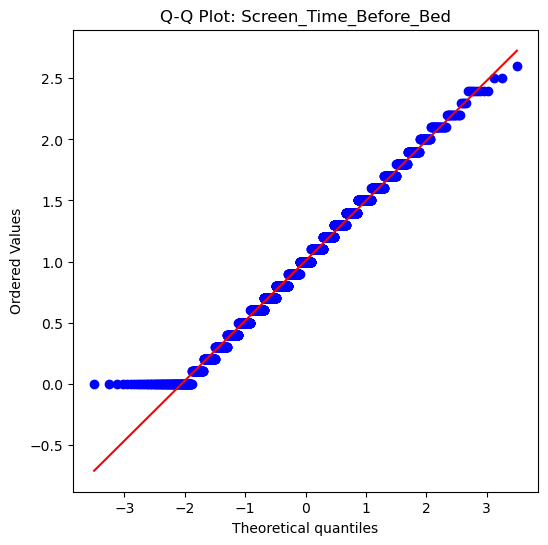


--------------------------------------------------
=== ЧАСТЬ III: Попытка нормализации ===
Применен метод: Удаление выбросов (IQR) -> Логарифмирование.
Размер выборки до: 3000, после: 2997


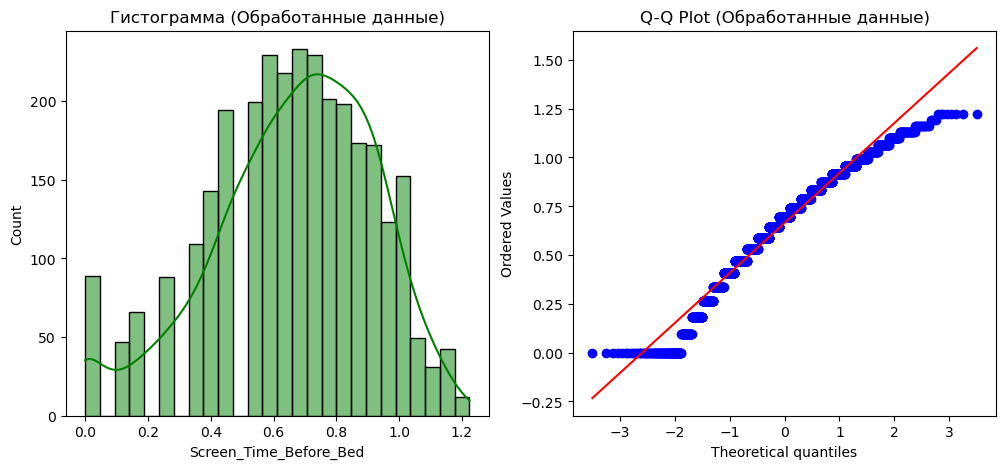


[Ручной Хи-квадрат]
Статистика: 581.3723 | Критическое значение: 16.9190
Вывод: Гипотеза о нормальности ОТВЕРГАЕТСЯ.

--------------------------------------------------
=== ЧАСТЬ IV: Группировка по классам (School_Grade) ===
                  mean       var  count
School_Grade                           
10th          1.020945  0.240960    487
11th          1.022547  0.233507    479
12th          0.982420  0.243762    529
7th           1.006640  0.254694    497
8th           1.005187  0.241366    482
9th           1.005133  0.244107    526


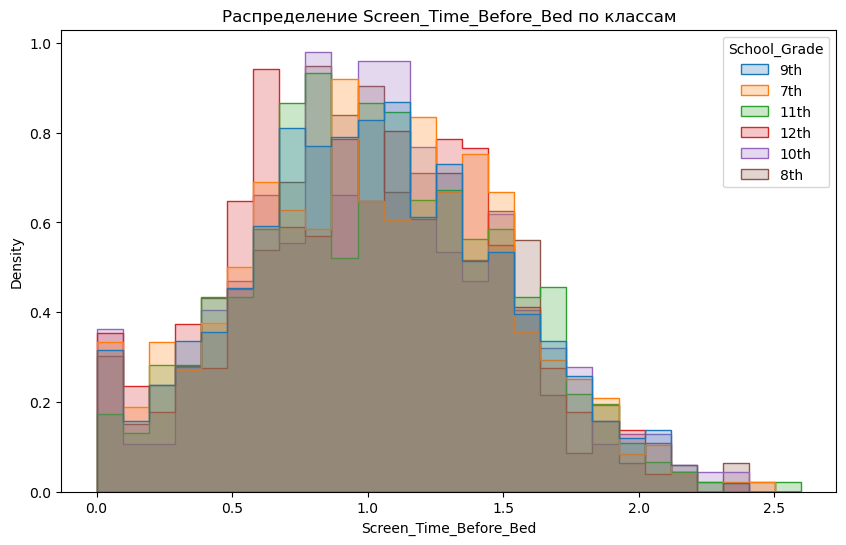

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# ---------------------------------------------------------
# 1. ЗАГРУЗКА ДАННЫХ
# ---------------------------------------------------------
# Файл должен лежать в той же папке, что и этот скрипт
filename = 'teen_phone_addiction_dataset.csv'

try:
    df = pd.read_csv(filename)
    print(f"Файл '{filename}' успешно загружен.")
except FileNotFoundError:
    print(f"ОШИБКА: Файл '{filename}' не найден. Убедитесь, что он лежит в одной папке с кодом.")
    df = pd.DataFrame()

if not df.empty:
    # ---------------------------------------------------------
    # ВЫБОР СТОЛБЦА (N = 10)
    # ---------------------------------------------------------
    N = 10
    # Список столбцов (порядок важен для формулы N % 7)
    cols = ['Daily_Usage_Hours', 'Sleep_Hours', 'Exercise_Hours', 
            'Screen_Time_Before_Bed', 'Time_on_Social_Media', 
            'Time_on_Gaming', 'Time_on_Education']
    
    # 10 % 7 = 3 -> Screen_Time_Before_Bed
    col_index = N % len(cols)
    col_name = cols[col_index]
    
    # Берём данные и убираем пустые значения, если есть
    data = df[col_name].dropna()

    print(f"Вариант N={N}. Индекс: {col_index}.")
    print(f"Выбран столбец для анализа: {col_name}\n")
    print("-" * 50)

    # ---------------------------------------------------------
    # ЧАСТЬ I. Характеристики и Графики
    # ---------------------------------------------------------
    print("=== ЧАСТЬ I: Описательная статистика ===\n")

    stats_dict = {
        "1. Среднее": data.mean(),
        "2. Дисперсия (несмещенная)": data.var(ddof=1),
        "3. Мода": data.mode().iloc[0],
        "4. Медиана": data.median(),
        "5. Квантили (0.25, 0.5, 0.75)": data.quantile([0.25, 0.5, 0.75]).values,
        "6. Эксцесс (Fisher)": stats.kurtosis(data, fisher=True),
        "7. Асимметрия": stats.skew(data),
        "8. IQR (Интерквартильный размах)": stats.iqr(data)
    }

    for k, v in stats_dict.items():
        print(f"{k}: {v}")

    # Графики Части I
    plt.figure(figsize=(12, 5))

    # Гистограмма
    plt.subplot(1, 2, 1)
    plt.hist(data, bins='auto', density=False, alpha=0.6, color='skyblue', edgecolor='black')
    plt.title(f"Гистограмма: {col_name}")
    plt.xlabel("Часы")
    plt.ylabel("Количество")

    # Эмпирическая функция распределения (ECDF)
    plt.subplot(1, 2, 2)
    sorted_data = np.sort(data)
    yvals = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    plt.step(sorted_data, yvals, where='post', color='purple')
    plt.title("Эмпирическая функция распределения")
    plt.xlabel("Часы")
    plt.ylabel("F(x)")
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

    # ---------------------------------------------------------
    # ЧАСТЬ II. Проверка нормальности (Ручная реализация)
    # ---------------------------------------------------------
    print("\n" + "-" * 50)
    print("=== ЧАСТЬ II: Проверка на нормальность ===")

    # --- 1. Ручной расчет Хи-квадрат ---
    def manual_chi_square_test(series, alpha=0.05):
        n = len(series)
        # Правило Старджесса для количества корзин
        k = 1 + int(np.log2(n))
        
        # Получаем наблюдаемые частоты (Oi)
        obs_freq, bin_edges = np.histogram(series, bins=k)
        
        # Параметры распределения
        mu = series.mean()
        sigma = series.std(ddof=1)
        
        # Считаем ожидаемые частоты (Ei) через разность CDF
        exp_freq = []
        for i in range(k):
            upper = bin_edges[i+1]
            lower = bin_edges[i]
            # Вероятность попадания в интервал * объем выборки
            prob = stats.norm.cdf(upper, mu, sigma) - stats.norm.cdf(lower, mu, sigma)
            exp_freq.append(prob * n)
        
        exp_freq = np.array(exp_freq)
        # Защита от деления на ноль
        exp_freq = np.where(exp_freq < 1e-9, 1e-9, exp_freq)
        
        # Статистика
        chi_stat = np.sum((obs_freq - exp_freq)**2 / exp_freq)
        
        # Степени свободы (k интервалов - 1 - 2 параметра (mean, std))
        dof = max(1, k - 3)
        
        # Критическое значение и p-value
        crit_val = stats.chi2.ppf(1 - alpha, dof)
        p_val = 1 - stats.chi2.cdf(chi_stat, dof)
        
        print(f"\n[Ручной Хи-квадрат]")
        print(f"Статистика: {chi_stat:.4f} | Критическое значение: {crit_val:.4f}")
        if chi_stat < crit_val:
            print("Вывод: Гипотеза о нормальности НЕ отвергается (данные похожи на нормальные).")
        else:
            print("Вывод: Гипотеза о нормальности ОТВЕРГАЕТСЯ.")

    manual_chi_square_test(data)

    # --- 2. Критерий Асимметрии и Эксцесса (через Z-оценки) ---
    def skew_kurt_check(series):
        n = len(series)
        sk = stats.skew(series)
        ku = stats.kurtosis(series, fisher=True)
        
        # Стандартные ошибки
        se_sk = np.sqrt(6/n)
        se_ku = np.sqrt(24/n)
        
        z_sk = sk / se_sk
        z_ku = ku / se_ku
        
        print(f"\n[Критерий Асимметрии и Эксцесса]")
        print(f"Асимметрия: {sk:.3f} (Z = {z_sk:.3f})")
        print(f"Эксцесс:    {ku:.3f} (Z = {z_ku:.3f})")
        
        # Критическое значение Z для alpha=0.05 (1.96)
        if abs(z_sk) < 1.96 and abs(z_ku) < 1.96:
            print("Вывод: Показатели в пределах нормы (|Z| < 1.96).")
        else:
            print("Вывод: Показатели выходят за пределы нормы.")

    skew_kurt_check(data)

    # --- 3. Q-Q Plot ---
    plt.figure(figsize=(6, 6))
    stats.probplot(data, dist="norm", plot=plt)
    plt.title(f"Q-Q Plot: {col_name}")
    plt.show()

    # ---------------------------------------------------------
    # ЧАСТЬ III. Обработка данных
    # ---------------------------------------------------------
    print("\n" + "-" * 50)
    print("=== ЧАСТЬ III: Попытка нормализации ===")

    # Метод: Удаление выбросов + Логарифмирование
    # 1. Сначала удаляем жесткие выбросы по IQR
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    filtered = data[(data >= Q1 - 1.5*IQR) & (data <= Q3 + 1.5*IQR)]

    # 2. Логарифмируем (добавляем маленькую константу, если есть 0)
    # log1p вычисляет log(1 + x)
    processed_data = np.log1p(filtered)

    print("Применен метод: Удаление выбросов (IQR) -> Логарифмирование.")
    print(f"Размер выборки до: {len(data)}, после: {len(processed_data)}")

    # Проверка новых данных
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(processed_data, kde=True, color='green')
    plt.title("Гистограмма (Обработанные данные)")
    
    plt.subplot(1, 2, 2)
    stats.probplot(processed_data, dist="norm", plot=plt)
    plt.title("Q-Q Plot (Обработанные данные)")
    plt.show()

    # Повторный тест Хи-квадрат
    manual_chi_square_test(processed_data)

    # ---------------------------------------------------------
    # ЧАСТЬ IV. Группировка
    # ---------------------------------------------------------
    print("\n" + "-" * 50)
    print("=== ЧАСТЬ IV: Группировка по классам (School_Grade) ===")

    # Группируем исходный датафрейм
    grouped = df.groupby('School_Grade')[col_name]

    # Таблица статистик
    print(grouped.agg(['mean', 'var', 'count']))

    # Общий график
    plt.figure(figsize=(10, 6))
    # Рисуем гистограммы (KDE) для каждого класса на одном поле
    sns.histplot(data=df, x=col_name, hue="School_Grade", element="step", stat="density", common_norm=False)
    plt.title(f"Распределение {col_name} по классам")
    plt.show()

    